In [72]:
from ArticlesRep import MeanSimilarityoneindustry,MeanSimilaritytwoindustry #common function

import pandas as pd

import numpy as np

%matplotlib inline

import pickle

import visdom

from tqdm import tnrange, tqdm_notebook
from tqdm.autonotebook import tqdm
tqdm.pandas()

from time import time,sleep
from datetime import datetime

from sklearn.metrics.pairwise import cosine_similarity
# import visdom
# vis=visdom.Visdom()
# env="TagBased"

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning,)
# %matplotlib inline

import re

from pprint import pprint
#coding:utf-8
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
#有中文出现的情况，需要u'内容'
list_industry=["水泥","食品飲料","石化","紡織","電機機械","電器電纜","化學工業",
               "建材居家用品","造紙","鋼鐵金屬","車輛相關","科技相關","營建地產","運輸","觀光休閒娛樂",
               "金融相關","百貨通路","公用事業","控股","生技醫療保健","農林漁牧","航天軍工","能源","傳播出版","綜合",
               "傳產其他","其他","金屬礦採選",
              ]

In [73]:
from keras.layers import Dense,Lambda,Input,Dot,Add,Subtract,GaussianDropout
from keras.utils import Sequence,plot_model
from keras.models import Model,load_model
from keras import backend as K


### Denoising Autoencoder with weak supervision

In [94]:
# custommed function
def noisefunction(x):
    x_noise=K.ones_like(x)
    return K.in_train_phase(x_noise,x,1)

def tripletlossfunction(inputs):
    r01=inputs[0]
    r02=inputs[1]
    loss=K.log(1+K.exp(r02-r01))
#     x=np.array([[0],[1],[0],[1]])
#     x=K.variable(x)
    return loss

def losspassfunction(y_true,y_pred):
    return y_pred

def test(inputs):
#     x=K.dot(inputs,k.transpose(inputs))
    x=K.transpose(inputs)
    return x

In [95]:
x=Input(shape=(5,))
y=Lambda(noisefunction)(x)
model=Model(x,y)
x=np.arange(2*5).reshape((2,5))
model.predict(x)

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]], dtype=float32)

In [197]:
K.clear_session()
np.random.seed(100)
###############
# instantiate layer
# noise=Lambda(noisefunction,name="noisefunction")
# trilosslayer=Lambda(Triplet,name="trilosslayer")
# dense=Dense(units=12000,activation="sigmoid",name="Dense1")
###############
#parameter setting
BOW_dim=20000
DR_dim=100
loss_weights=[1,1,1,1]

##Encoder
x=Input((BOW_dim,),name="encoder_input")
# y=Lambda(noisefunction,name="noisefunction")
y=GaussianDropout(rate=0.2,name="noise")(x)
# y=Dense(30,use_bias=False)(y)
y=Dense(units=DR_dim,activation="sigmoid",name="Dense",use_bias=False)(y)
encoder=Model(x,y,name="encoder")

##Decoder
x=Input((DR_dim,),name="input") 
y=Dense(units=20000,activation="sigmoid",name="Dense")(x)
decoder=Model(x,y,name="decoder")

##Tripletloss
x0=Input((DR_dim,),name="anchor_input")
x1=Input((DR_dim,),name="positive_input")
x2=Input((DR_dim,),name="negative_input")
r01=Dot(axes=1,name="SimiPositive")([x0,x1])
r02=Dot(axes=1,name="SimiNegative")([x0,x2])
out=Lambda(tripletlossfunction,name="tripletlossfunction")([r01,r02])
tripletloss=Model(inputs=[x0,x1,x2],outputs=out,name="triplet")

#Build Tri-Autoencoder model
x0=Input((BOW_dim,),name="anchor_input")
x1=Input((BOW_dim,),name="positive_input")
x2=Input((BOW_dim,),name="negative_input")

h0=encoder(x0)
h1=encoder(x1)
h2=encoder(x2)

Lt=tripletloss([h0,h1,h2])

y0=decoder(h0)
y1=decoder(h1)
y2=decoder(h2)

y0=Lambda(lambda x :x ,name="anchor")(y0)
y1=Lambda(lambda x :x ,name="positive")(y1)
y2=Lambda(lambda x :x ,name="negative")(y2)

# triplet_loss

Tri_AutoEncoder=Model(inputs=[x0,x1,x2],outputs=[y0,y1,y2,Lt])
Tri_AutoEncoder.compile(optimizer="adam",
                        loss=['binary_crossentropy','binary_crossentropy','binary_crossentropy',losspassfunction],
                        loss_weights=loss_weights
                       )
#save initial model
Tri_AutoEncoder.save("Tri_AutoEncoder.initial.h5")
encoder.save("encoder.initial.h5")
decoder.save("decoder.initial.h5")
#plot
plot_model(Tri_AutoEncoder,to_file="Tri_DenoiseAutoEncoder.png")
plot_model(encoder,to_file="encoder.png")
plot_model(decoder,to_file="decoder.png")
# Open the file to record
with open('Tri_AutoEencoderncoder.summary.txt','w') as f:
    # Pass the file handle in as a lambda function to make it callable
    Tri_AutoEncoder.summary(print_fn=lambda x: f.write("    "+x + '\n'))
with open('encoder.summary.txt','w') as f:
    # Pass the file handle in as a lambda function to make it callable
    encoder.summary(print_fn=lambda x: f.write("    "+x + '\n'))
with open('decoder.summary.txt','w') as f:
    # Pass the file handle in as a lambda function to make it callable
    decoder.summary(print_fn=lambda x: f.write("    "+x + '\n'))

Tri_AutoEncoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       (None, 20000)        0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     (None, 20000)        0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     (None, 20000)        0                                            
__________________________________________________________________________________________________
encoder (Model)                 (None, 100)          2000000     anchor_input[0][0]               
                                                                 positive_input[0][0]             
          

## Load Data

In [6]:
# Data=np.load("D:3.AutoencoderForArticle/BOW_binary_v01.npy")

In [7]:
# with open("D:3.AutoencoderForArticle/train_dict_collect_small_industry","rb") as f:
#     train_dict_collect_small_industry=pickle.load(f)
# with open("D:3.AutoencoderForArticle/train_dict_small_triplet_v02","rb") as f:
#     train_dict_small_triplet_v02=pickle.load(f)
# with open("D:3.AutoencoderForArticle/test_dict_collect_small_industry","rb") as f:
#     test_dict_collect_small_industry=pickle.load(f)
# with open("D:3.AutoencoderForArticle/test_dict_small_triplet_v02","rb") as f:
#     test_dict_small_triplet_v02=pickle.load(f)

In [8]:
#train treiplet
for i,k in enumerate(train_dict_small_triplet_v02):
    if i==0:train_tripletindex=train_dict_small_triplet_v02[k]
    else:train_tripletindex=np.concatenate((train_tripletindex,train_dict_small_triplet_v02[k]),axis=0)

In [9]:
len(train_tripletindex)

181054122

In [10]:
total=0
for k in train_dict_small_triplet_v02:
    total+=len(train_dict_small_triplet_v02[k])
total

181054122

In [11]:
#test treiplet
for i,k in enumerate(test_dict_small_triplet_v02):
    if i==0:test_tripletindex=test_dict_small_triplet_v02[k]
    else:test_tripletindex=np.concatenate((test_tripletindex,test_dict_small_triplet_v02[k]),axis=0)

In [12]:
len(test_tripletindex)

2900703

In [13]:
total=0
for k in test_dict_small_triplet_v02:
    total+=len(test_dict_small_triplet_v02[k])
total

2900703

In [ ]:
# %%time
# np.random.permutation(train_tripletindex)

In [ ]:
# %%time
# np.random.shuffle(train_tripletindex)

In [ ]:
# %%time
# pick=np.random.permutation(181054122)
# train_tripletindex[pick]

In [20]:
%%time
b=32
batch_index = train_tripletindex[0 * b:(0 + 1) * b]
pprint(batch_index)

array([[139125,  40333, 124597],
       [139125,  40333,  60321],
       [139125,  40333,  71898],
       [139125,  40333,  19556],
       [139125,  40333, 132283],
       [139125,  40333,  15270],
       [139125,  40333,  43447],
       [139125,  40333, 106279],
       [139125,  40333, 108631],
       [139125,  40333, 100437],
       [139125,  40333,  83751],
       [139125,  40333, 128242],
       [139125,  40333,  79813],
       [139125,  40333,  73970],
       [139125,  40333, 115913],
       [139125,  40333,  14928],
       [139125,  40333, 143465],
       [139125,  40333, 145715],
       [139125,  40333,  70825],
       [139125,  40333,  76598],
       [139125,  40333,   5230],
       [139125,  40333,  74185],
       [139125,  40333,  50990],
       [139125,  40333,  63637],
       [139125,  40333,  60053],
       [139125,  40333,  94387],
       [139125,  40333, 123870],
       [139125,  40333,  80943],
       [139125,  40333,  89880],
       [139125,  40333, 144565],
       [13

## Data generator

In [139]:
class DataGenerator(Sequence):

    def __init__(self, tripletindex,Data, batch_size=32):
        self.tripletindex= np.asarray(tripletindex)
        pick=np.random.permutation(len(self.tripletindex))
        self.tripletindex= self.tripletindex[pick]
        self.batch_size = batch_size

    def __len__(self):
#         return int(np.ceil(self.tripletindex.shape[0] / float(self.batch_size)))
        return 100
    def __getitem__(self, idx):
        batch_index = self.tripletindex[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_anchor = Data[batch_index[:,0]]
        batch_positive = Data[batch_index[:,1]]
        batch_negative = Data[batch_index[:,2]]
        tripletloss=np.zeros((batch_negative.shape[0],1))
        return [batch_anchor,batch_positive,batch_negative],[batch_anchor,batch_positive,batch_negative,tripletloss]
    def on_epoch_end(self):
        """Method called at the end of every epoch.
        """
        
#         pick=np.random.permutation(len(self.tripletindex))
#         self.tripletindex= self.tripletindex[pick]
        

In [140]:
%%time
# train0=np.random.randint(0,2,(4,12000))
# train1=np.random.randint(0,2,(4,12000))
# train2=np.random.randint(0,2,(4,12000))
# labels=np.ones((4,1))


#setup

batch_size=32
#instantiate generator
traingenerator=DataGenerator(tripletindex=train_tripletindex,
                             Data=Data,
                             batch_size=batch_size)
testgenerator=DataGenerator(tripletindex=test_tripletindex,
                            Data=Data,
                            batch_size=batch_size)

Wall time: 19.9 s


In [173]:
%%time
#setup
epochs=200
# steps_per_epoch=5
#train
History=Tri_AutoEncoder.fit_generator(generator=traingenerator,
                                      shuffle=True,
                                      epochs=epochs,
#                                       steps_per_epoch=steps_per_epoch,
                                      validation_data=testgenerator,
                                      verbose=2,
                                      workers=3,use_multiprocessing=False,
                                    
                                     )

Epoch 1/200
 - 15s - loss: 0.0685 - anchor_loss: 0.0222 - positive_loss: 0.0228 - negative_loss: 0.0220 - triplet_loss: 0.0014 - val_loss: 0.2883 - val_anchor_loss: 0.0226 - val_positive_loss: 0.0225 - val_negative_loss: 0.0227 - val_triplet_loss: 0.2204
Epoch 2/200
 - 15s - loss: 0.0680 - anchor_loss: 0.0221 - positive_loss: 0.0227 - negative_loss: 0.0219 - triplet_loss: 0.0012 - val_loss: 0.2887 - val_anchor_loss: 0.0226 - val_positive_loss: 0.0225 - val_negative_loss: 0.0226 - val_triplet_loss: 0.2210
Epoch 3/200
 - 15s - loss: 0.0677 - anchor_loss: 0.0220 - positive_loss: 0.0226 - negative_loss: 0.0218 - triplet_loss: 0.0012 - val_loss: 0.2872 - val_anchor_loss: 0.0226 - val_positive_loss: 0.0225 - val_negative_loss: 0.0226 - val_triplet_loss: 0.2196
Epoch 4/200
 - 15s - loss: 0.0672 - anchor_loss: 0.0219 - positive_loss: 0.0225 - negative_loss: 0.0217 - triplet_loss: 0.0011 - val_loss: 0.2862 - val_anchor_loss: 0.0225 - val_positive_loss: 0.0224 - val_negative_loss: 0.0225 - val_t

Epoch 33/200
 - 15s - loss: 0.0535 - anchor_loss: 0.0175 - positive_loss: 0.0182 - negative_loss: 0.0174 - triplet_loss: 3.2638e-04 - val_loss: 0.2685 - val_anchor_loss: 0.0213 - val_positive_loss: 0.0212 - val_negative_loss: 0.0213 - val_triplet_loss: 0.2048
Epoch 34/200
 - 15s - loss: 0.0529 - anchor_loss: 0.0173 - positive_loss: 0.0180 - negative_loss: 0.0172 - triplet_loss: 3.2071e-04 - val_loss: 0.2672 - val_anchor_loss: 0.0212 - val_positive_loss: 0.0211 - val_negative_loss: 0.0213 - val_triplet_loss: 0.2035
Epoch 35/200
 - 15s - loss: 0.0523 - anchor_loss: 0.0171 - positive_loss: 0.0178 - negative_loss: 0.0170 - triplet_loss: 3.0230e-04 - val_loss: 0.2660 - val_anchor_loss: 0.0212 - val_positive_loss: 0.0211 - val_negative_loss: 0.0212 - val_triplet_loss: 0.2024
Epoch 36/200
 - 15s - loss: 0.0516 - anchor_loss: 0.0169 - positive_loss: 0.0176 - negative_loss: 0.0168 - triplet_loss: 2.9152e-04 - val_loss: 0.2648 - val_anchor_loss: 0.0212 - val_positive_loss: 0.0211 - val_negative_

Epoch 65/200
 - 15s - loss: 0.0317 - anchor_loss: 0.0104 - positive_loss: 0.0108 - negative_loss: 0.0103 - triplet_loss: 2.3264e-04 - val_loss: 0.2407 - val_anchor_loss: 0.0207 - val_positive_loss: 0.0206 - val_negative_loss: 0.0208 - val_triplet_loss: 0.1786
Epoch 66/200
 - 15s - loss: 0.0311 - anchor_loss: 0.0102 - positive_loss: 0.0106 - negative_loss: 0.0102 - triplet_loss: 2.3441e-04 - val_loss: 0.2394 - val_anchor_loss: 0.0207 - val_positive_loss: 0.0206 - val_negative_loss: 0.0208 - val_triplet_loss: 0.1773
Epoch 67/200
 - 15s - loss: 0.0306 - anchor_loss: 0.0100 - positive_loss: 0.0104 - negative_loss: 0.0100 - triplet_loss: 2.3848e-04 - val_loss: 0.2384 - val_anchor_loss: 0.0207 - val_positive_loss: 0.0206 - val_negative_loss: 0.0208 - val_triplet_loss: 0.1763
Epoch 68/200
 - 15s - loss: 0.0301 - anchor_loss: 0.0098 - positive_loss: 0.0102 - negative_loss: 0.0098 - triplet_loss: 2.3168e-04 - val_loss: 0.2380 - val_anchor_loss: 0.0207 - val_positive_loss: 0.0206 - val_negative_

Epoch 97/200
 - 15s - loss: 0.0198 - anchor_loss: 0.0065 - positive_loss: 0.0067 - negative_loss: 0.0065 - triplet_loss: 2.3214e-04 - val_loss: 0.2361 - val_anchor_loss: 0.0217 - val_positive_loss: 0.0215 - val_negative_loss: 0.0217 - val_triplet_loss: 0.1712
Epoch 98/200
 - 15s - loss: 0.0196 - anchor_loss: 0.0064 - positive_loss: 0.0066 - negative_loss: 0.0064 - triplet_loss: 2.3958e-04 - val_loss: 0.2344 - val_anchor_loss: 0.0217 - val_positive_loss: 0.0215 - val_negative_loss: 0.0217 - val_triplet_loss: 0.1694
Epoch 99/200
 - 15s - loss: 0.0194 - anchor_loss: 0.0063 - positive_loss: 0.0065 - negative_loss: 0.0063 - triplet_loss: 2.3255e-04 - val_loss: 0.2357 - val_anchor_loss: 0.0218 - val_positive_loss: 0.0216 - val_negative_loss: 0.0218 - val_triplet_loss: 0.1705
Epoch 100/200
 - 15s - loss: 0.0192 - anchor_loss: 0.0063 - positive_loss: 0.0065 - negative_loss: 0.0063 - triplet_loss: 2.4098e-04 - val_loss: 0.2374 - val_anchor_loss: 0.0218 - val_positive_loss: 0.0217 - val_negative

Epoch 129/200
 - 15s - loss: 0.0149 - anchor_loss: 0.0049 - positive_loss: 0.0050 - negative_loss: 0.0048 - triplet_loss: 2.1958e-04 - val_loss: 0.2419 - val_anchor_loss: 0.0234 - val_positive_loss: 0.0233 - val_negative_loss: 0.0235 - val_triplet_loss: 0.1718
Epoch 130/200
 - 15s - loss: 0.0148 - anchor_loss: 0.0048 - positive_loss: 0.0050 - negative_loss: 0.0048 - triplet_loss: 2.1562e-04 - val_loss: 0.2439 - val_anchor_loss: 0.0235 - val_positive_loss: 0.0234 - val_negative_loss: 0.0236 - val_triplet_loss: 0.1735
Epoch 131/200
 - 15s - loss: 0.0147 - anchor_loss: 0.0048 - positive_loss: 0.0049 - negative_loss: 0.0048 - triplet_loss: 2.2439e-04 - val_loss: 0.2416 - val_anchor_loss: 0.0235 - val_positive_loss: 0.0234 - val_negative_loss: 0.0235 - val_triplet_loss: 0.1712
Epoch 132/200
 - 15s - loss: 0.0146 - anchor_loss: 0.0048 - positive_loss: 0.0049 - negative_loss: 0.0047 - triplet_loss: 2.2239e-04 - val_loss: 0.2430 - val_anchor_loss: 0.0235 - val_positive_loss: 0.0234 - val_negat

Epoch 161/200
 - 15s - loss: 0.0124 - anchor_loss: 0.0040 - positive_loss: 0.0041 - negative_loss: 0.0040 - triplet_loss: 2.1761e-04 - val_loss: 0.2503 - val_anchor_loss: 0.0252 - val_positive_loss: 0.0251 - val_negative_loss: 0.0253 - val_triplet_loss: 0.1747
Epoch 162/200
 - 15s - loss: 0.0123 - anchor_loss: 0.0040 - positive_loss: 0.0041 - negative_loss: 0.0040 - triplet_loss: 2.0811e-04 - val_loss: 0.2511 - val_anchor_loss: 0.0253 - val_positive_loss: 0.0253 - val_negative_loss: 0.0254 - val_triplet_loss: 0.1751
Epoch 163/200
 - 15s - loss: 0.0122 - anchor_loss: 0.0040 - positive_loss: 0.0041 - negative_loss: 0.0040 - triplet_loss: 2.1196e-04 - val_loss: 0.2538 - val_anchor_loss: 0.0254 - val_positive_loss: 0.0254 - val_negative_loss: 0.0255 - val_triplet_loss: 0.1774
Epoch 164/200
 - 15s - loss: 0.0122 - anchor_loss: 0.0040 - positive_loss: 0.0041 - negative_loss: 0.0040 - triplet_loss: 2.1198e-04 - val_loss: 0.2533 - val_anchor_loss: 0.0253 - val_positive_loss: 0.0253 - val_negat

Epoch 193/200
 - 15s - loss: 0.0107 - anchor_loss: 0.0035 - positive_loss: 0.0036 - negative_loss: 0.0035 - triplet_loss: 2.0208e-04 - val_loss: 0.2614 - val_anchor_loss: 0.0270 - val_positive_loss: 0.0270 - val_negative_loss: 0.0271 - val_triplet_loss: 0.1804
Epoch 194/200
 - 15s - loss: 0.0107 - anchor_loss: 0.0035 - positive_loss: 0.0036 - negative_loss: 0.0035 - triplet_loss: 2.0558e-04 - val_loss: 0.2618 - val_anchor_loss: 0.0271 - val_positive_loss: 0.0271 - val_negative_loss: 0.0272 - val_triplet_loss: 0.1804
Epoch 195/200
 - 15s - loss: 0.0107 - anchor_loss: 0.0035 - positive_loss: 0.0035 - negative_loss: 0.0035 - triplet_loss: 2.1452e-04 - val_loss: 0.2669 - val_anchor_loss: 0.0271 - val_positive_loss: 0.0271 - val_negative_loss: 0.0272 - val_triplet_loss: 0.1856
Epoch 196/200
 - 15s - loss: 0.0106 - anchor_loss: 0.0034 - positive_loss: 0.0035 - negative_loss: 0.0034 - triplet_loss: 2.0284e-04 - val_loss: 0.2669 - val_anchor_loss: 0.0272 - val_positive_loss: 0.0273 - val_negat

In [186]:
Tri_AutoEncoder.save("Tri_AutoEncoder_trained.h5")
encoder.save("encoder_trained.h5")
decoder.save("decoder_trained.h5")

In [175]:
df=pd.DataFrame(History.history)

In [188]:
df.to_hdf("history.h5",key="data")

In [189]:
# df=pd.read_hdf("history.h5")

In [190]:
# df[["loss","val_loss"]].plot(subplots=False,layout=(1,3),figsize=(18,6))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000025432A86DD8>,
      dtype=object)

C:\Users\garyyu\AppData\Local\Continuum\anaconda3\envs\deeplearningcpu\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


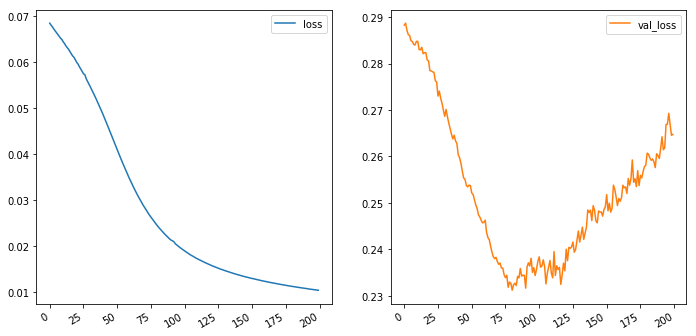

In [191]:
df[["loss","val_loss"]].plot(subplots=True,layout=(1,3),figsize=(18,6))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000025433D24B70>,
      dtype=object)

C:\Users\garyyu\AppData\Local\Continuum\anaconda3\envs\deeplearningcpu\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


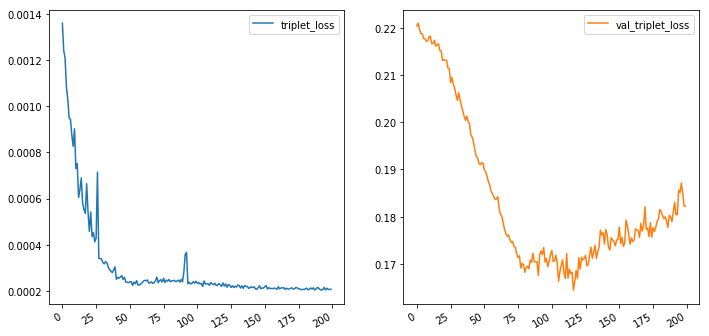

In [192]:
df[["triplet_loss","val_triplet_loss"]].plot(subplots=True,layout=(1,3),figsize=(18,6))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000025433E89F28>,
      dtype=object)

C:\Users\garyyu\AppData\Local\Continuum\anaconda3\envs\deeplearningcpu\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


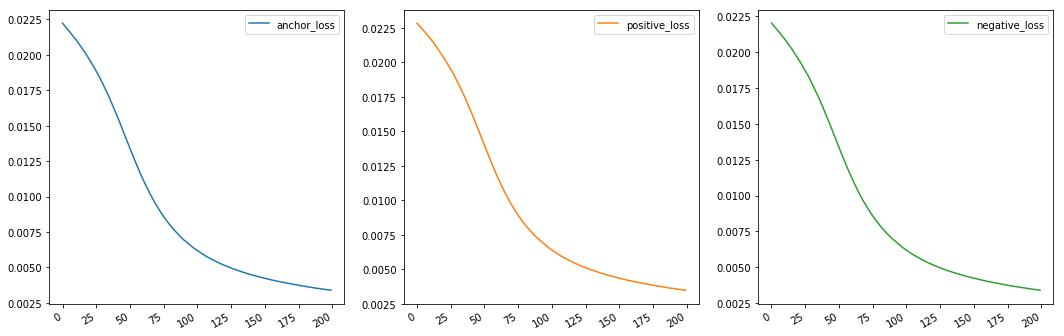

In [193]:
df[["anchor_loss","positive_loss","negative_loss"]].plot(subplots=True,layout=(1,3),figsize=(18,6))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000025432CF9550>,
      dtype=object)

C:\Users\garyyu\AppData\Local\Continuum\anaconda3\envs\deeplearningcpu\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


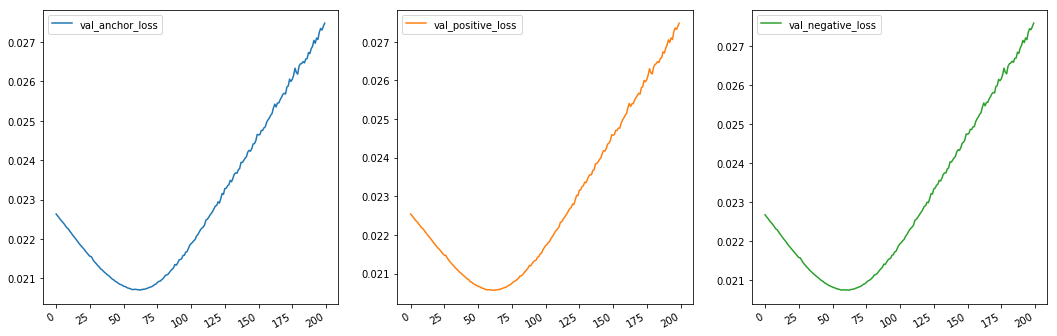

In [194]:
df[["val_anchor_loss","val_positive_loss","val_negative_loss"]].plot(subplots=True,layout=(1,3),figsize=(18,6))

In [195]:
df.to_hdf("history.h5",key="data")

In [196]:
pd.read_hdf("history.h5")

,anchor_loss,loss,negative_loss,positive_loss,triplet_loss,val_anchor_loss,val_loss,val_negative_loss,val_positive_loss,val_triplet_loss
0,0.022233,0.068454,0.022029,0.022831,0.001361,0.022635,0.288269,0.022671,0.022543,0.220420
1,0.022120,0.068007,0.021922,0.022723,0.001242,0.022593,0.288689,0.022624,0.022497,0.220974
2,0.022000,0.067651,0.021813,0.022627,0.001212,0.022551,0.287162,0.022583,0.022454,0.219574
3,0.021888,0.067181,0.021704,0.022506,0.001083,0.022501,0.286205,0.022533,0.022407,0.218764
4,0.021774,0.066790,0.021588,0.022398,0.001031,0.022461,0.286045,0.022487,0.022364,0.218734
5,0.021657,0.066364,0.021475,0.022282,0.000949,0.022423,0.284917,0.022454,0.022332,0.217708
6,0.021543,0.066029,0.021369,0.022172,0.000944,0.022381,0.284744,0.022407,0.022284,0.217672
7,0.021422,0.065604,0.021250,0.022055,0.000876,0.022330,0.284100,0.022359,0.022241,0.217170
8,0.021299,0.065186,0.021125,0.021936,0.000827,0.022286,0.283994,0.022309,0.022191,0.217208
9,0.021170,0.064897,0.021011,0.021813,0.000903,0.022262,0.284758,0.022288,0.022167,0.218041


In [199]:
import keras
print(keras.__version__)

2.2.4
